In [ ]:
#used this url for documentation NOAA "https://www.ncdc.noaa.gov/cdo-web/webservices/v2#data"

In [3]:
import requests
import pandas as pd
import numpy as np
import requests_cache
import plotnine as p9
import datetime

In [ ]:
#Station ID: GHCND:US1CASZ0029 #station nearest UCSC

In [70]:
token = 'tqQNQJTPRxOCdAucFBalBaEXMRnkZjvo' #web services token request to get access API
df = []
for i in range(2000,2021): #start and end parameters can only do one year so this is how you'll get all the years
    response = requests.get(url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&stationid=GHCND:USC00047916&datatypeid=TMAX&datatypeid=TMIN&datatypeid=PRCP&limit=1000&startdate="+str(i)+"-01-01&enddate="+str(i)+"-12-31&units=standard" , headers = {'token': token})
    response_js = response.json()
    #print(response_js)
    df_temp = pd.DataFrame(response_js["results"]) #want results part
    #print(df)  #df has to be in loop to get all the years  
    df.append(df_temp[['date', 'datatype', 'value']]) #get columns you want
#print(df) #appended entire dataframe to list to keep all the years, so won't have to work under for loop

In [151]:
station_df = pd.concat(df) #make list of iterated dataframes to one dataframe
station_df['date'] = pd.to_datetime(station_df['date'])
#print(station_df)
station_df = station_df.pivot_table('value', ['date'], 'datatype').reset_index()#leave date, make datatypes the columns and value as the column values corresponding to it, reset index to get own column for date
#print(station_df)
station_df['year'] = station_df['date'].dt.year #make year column getting year from datetime
print(station_df)
#station_df.year.dtype

datatype       date  PRCP  TMAX  TMIN  year
0        2000-01-01  0.00  54.0  47.0  2000
1        2000-01-02  0.02  59.0  35.0  2000
2        2000-01-03  0.00  60.0  36.0  2000
3        2000-01-04  0.00  58.0  36.0  2000
4        2000-01-05  0.00  62.0  39.0  2000
...             ...   ...   ...   ...   ...
6927     2020-12-26  0.20  60.0  48.0  2020
6928     2020-12-27  0.00  66.0  44.0  2020
6929     2020-12-29  0.00  62.0  37.0  2020
6930     2020-12-30  0.00  59.0  33.0  2020
6931     2020-12-31  0.30  65.0  42.0  2020

[6932 rows x 5 columns]


In [107]:
year_df_mean = station_df.groupby('year').mean().reset_index() #mean of all columns 
year_df_mean['diff'] = year_df_mean['TMAX'] - year_df_mean['TMIN']
print(year_df_mean)

datatype  year      PRCP       TMAX       TMIN       diff
0         2000  0.113892  66.972973  48.540541  18.432432
1         2001  0.075659  66.732733  48.345345  18.387387
2         2002  0.044940  66.498498  47.540541  18.957958
3         2003  0.039970  68.600601  49.090090  19.510511
4         2004  0.056467  68.384384  49.033033  19.351351
5         2005  0.081826  67.579580  49.372372  18.207207
6         2006  0.093713  66.873874  48.543544  18.330330
7         2007  0.034132  68.201201  47.570571  20.630631
8         2008  0.065898  68.912913  47.441441  21.471471
9         2009  0.062725  69.522523  47.924925  21.597598
10        2010  0.088743  68.414414  47.393393  21.021021
11        2011  0.259009  67.660274  46.194521  21.465753
12        2012  0.079834  70.002857  46.908309  23.094548
13        2013  0.014311  72.711712  47.588589  25.123123
14        2014  0.053862  73.807808  50.351351  23.456456
15        2015  0.030060  75.372372  50.147147  25.225225
16        2016

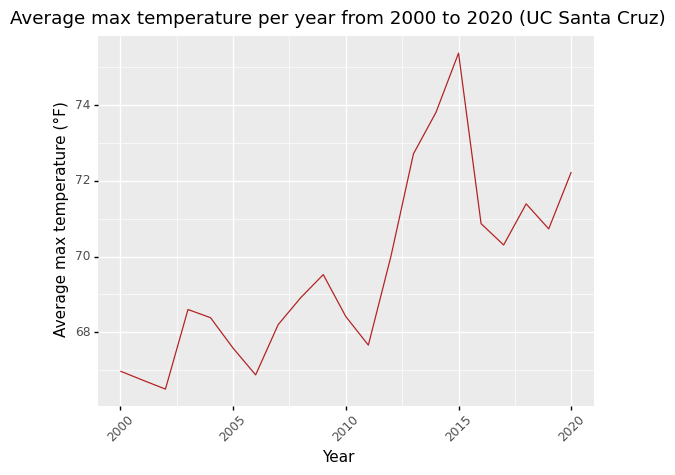

<ggplot: (96403366370)>

In [104]:
p9.ggplot(year_df_mean) + p9.aes(x='year',y='TMAX',group = 1) + \
p9.geom_line(color='firebrick') + p9.themes.theme(axis_text_x=p9.element_text(angle=45)) + \
p9.labs(x = "Year", y = "Average max temperature (°F)", \
     title = "Average max temperature per year from 2000 to 2020 (UC Santa Cruz)")

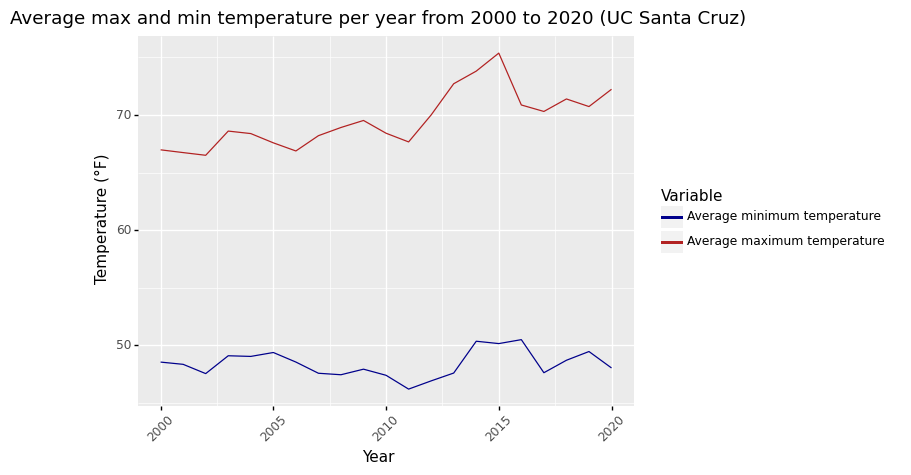

<ggplot: (96401816456)>

In [109]:
p9.ggplot(year_df_mean, p9.aes(x='year',y='TMIN',group = 1)) + \
p9.geom_line(p9.aes(y='TMIN', color='"darkblue"')) +\
p9.geom_line(p9.aes(y='TMAX', color='"firebrick"')) +\
p9.scale_color_identity(guide='legend', name = "Variable", breaks=['darkblue', 'firebrick'], 
                        labels=['Average minimum temperature', 'Average maximum temperature']) +\
p9.themes.theme(axis_text_x=p9.element_text(angle=45)) +\
p9.labs(x = "Year", y = "Temperature (°F)", \
     title = "Average max and min temperature per year from 2000 to 2020 (UC Santa Cruz)")

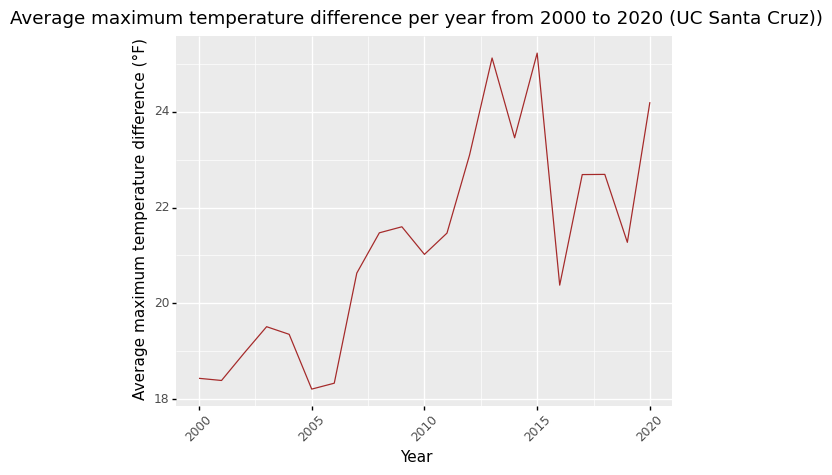

<ggplot: (96402570722)>

In [110]:
p9.ggplot(year_df_mean) + p9.aes(x='year',y='diff',group = 1) + p9.geom_line(color='brown') + p9.themes.theme(axis_text_x=p9.element_text(angle=45)) + \
p9.labs(x = "Year", y = "Average maximum temperature difference (°F)", \
     title = "Average maximum temperature difference per year from 2000 to 2020 (UC Santa Cruz))")

In [163]:
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
#Perform t-test to test for statistical evidence of difference in means:
station_df["year"] = station_df["year"].astype(str)
year_2000 = station_df[station_df['year'] == "2000"]["TMAX"].dropna()
print(year_2000)
year_2020 = station_df[station_df['year'] == "2020"]["TMAX"].dropna()
print(year_2020)
#Two sample t-test

print(stats.ttest_ind(a=year_2020,b=year_2000,alternative='greater'))
# 95% C.I. for 2000 and 2020
#print(stats.t.interval(alpha=0.95, df=len(year_2000)-1, loc=np.mean(year_2000), scale=stats.sem(year_2000)))
#print(stats.t.interval(alpha=0.95, df=len(year_2020)-1, loc=np.mean(year_2020), scale=stats.sem(year_2020)))

0      54.0
1      59.0
2      60.0
3      58.0
4      62.0
       ... 
328    63.0
329    61.0
330    60.0
331    63.0
332    65.0
Name: TMAX, Length: 333, dtype: float64
6656    61.0
6657    63.0
6658    69.0
6659    66.0
6660    69.0
        ... 
6927    60.0
6928    66.0
6929    62.0
6930    59.0
6931    65.0
Name: TMAX, Length: 268, dtype: float64
Ttest_indResult(statistic=7.465648545216531, pvalue=1.469102488796014e-13)


In [175]:
grps = [d['TMAX'].dropna().tolist() for _, d in station_df.groupby('year')]
print(stats.kruskal(*grps))

KruskalResult(statistic=547.3957488485881, pvalue=3.347101146953265e-103)


C:\Users\cecil\anaconda3\lib\site-packages\statsmodels\sandbox\stats\multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator


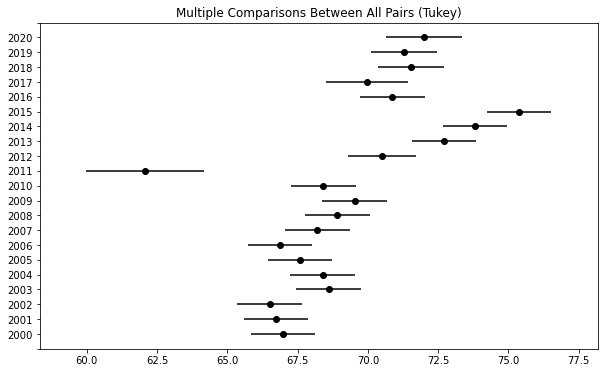

In [183]:
#plot Tukey simultaneous confidence intervals 
station_df = station_df.dropna()
tukey = pairwise_tukeyhsd(endog=station_df['TMAX'],groups=station_df['year'],alpha=0.05)
tukey_plot = tukey.plot_simultaneous()